# **Predicción de Series Temporales con RNN**

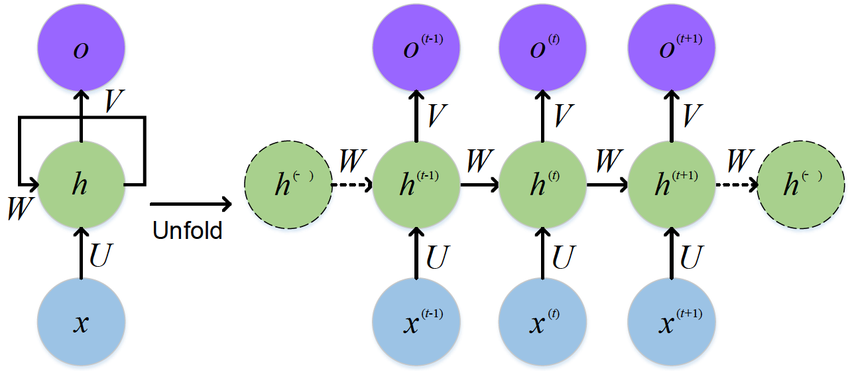

**Dataset: Temperaturas mínimas diarias en Malbourne (univariante, ~3,650 puntos).**

## **Instalaciones necesarias**

In [ ]:
# Instalaciones necesarias
!pip install torch torchvision torchaudio --quiet

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import math  # Para RMSE

# Verificar dispositivo (GPU si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## **Preparación del dataset**

          Date  Temp
0   1981-01-01  20.7
1   1981-01-02  17.9
2   1981-01-03  18.8
3   1981-01-04  14.6
4   1981-01-05  15.8
5   1981-01-06  15.8
6   1981-01-07  15.8
7   1981-01-08  17.4
8   1981-01-09  21.8
9   1981-01-10  20.0
10  1981-01-11  16.2
11  1981-01-12  13.3
12  1981-01-13  16.7
13  1981-01-14  21.5
14  1981-01-15  25.0
15  1981-01-16  20.7
16  1981-01-17  20.6
17  1981-01-18  24.8
18  1981-01-19  17.7
19  1981-01-20  15.5

Forma del dataset: (3650, 1)
Estadísticas: 
count    3650.000000
mean       11.177753
std         4.071837
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: Temp, dtype: float64


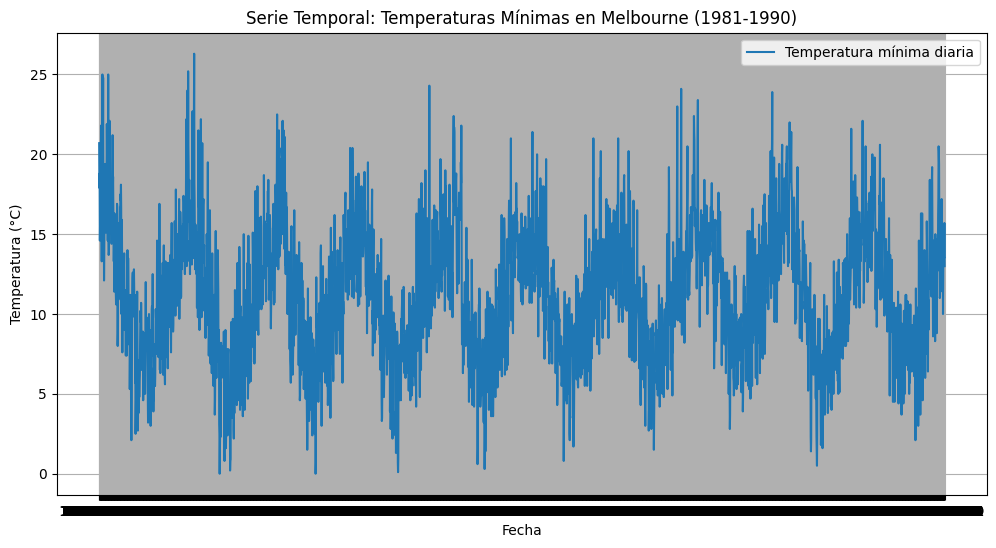

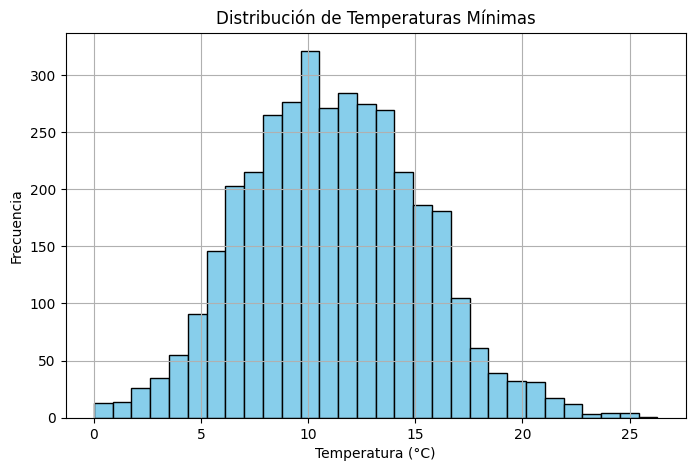

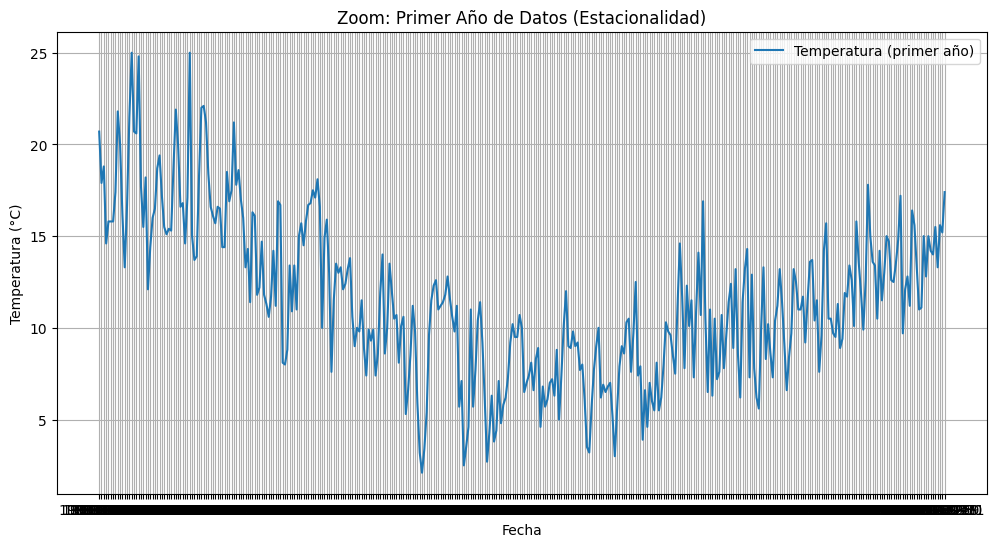

In [ ]:
# Cargar el dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)
data = df['Temp'].values.reshape(-1, 1)  # Columna de temperatura

# Información básica
print(df.head(20)) # Mostrar las primeras 20 filas
print(f"\nForma del dataset: {data.shape}")
print(f"Estadísticas: \n{df['Temp'].describe()}")

# Gráfico 1: Serie temporal completa
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Temp'], label='Temperatura mínima diaria')
plt.title('Serie Temporal: Temperaturas Mínimas en Melbourne (1981-1990)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2: Histograma de distribución
plt.figure(figsize=(8, 5))
plt.hist(df['Temp'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Temperaturas Mínimas')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Gráfico 3: Zoom en los primeros 365 días
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][:365], df['Temp'][:365], label='Temperatura (primer año)')
plt.title('Zoom: Primer Año de Datos (Estacionalidad)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

## **Normalización y división del datatset**

In [ ]:
# Normalizar
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Crear secuencias
time_step = 20
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, time_step)
X = torch.tensor(X, dtype=torch.float32).reshape(-1, time_step, 1).to(device)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)

# Dividir
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")

Forma de X_train: torch.Size([2904, 20, 1]), y_train: torch.Size([2904, 1])


## **Modelo RNN**

In [ ]:
class TimeSeriesRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Último paso
        return out

# Instanciar el modelo RNN
model = TimeSeriesRNN(input_size=1, hidden_size=50, output_size=1).to(device)
print(model)

TimeSeriesRNN(
  (rnn): RNN(1, 50, num_layers=3, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


## **Bucle de entrenamiento**

Epoch [1/20], Loss: 0.033064
Epoch [2/20], Loss: 0.013656
Epoch [3/20], Loss: 0.012225
Epoch [4/20], Loss: 0.010048
Epoch [5/20], Loss: 0.011703
Epoch [6/20], Loss: 0.009878
Epoch [7/20], Loss: 0.010180
Epoch [8/20], Loss: 0.009465
Epoch [9/20], Loss: 0.011115
Epoch [10/20], Loss: 0.010009
Epoch [11/20], Loss: 0.010082
Epoch [12/20], Loss: 0.010001
Epoch [13/20], Loss: 0.010307
Epoch [14/20], Loss: 0.009708
Epoch [15/20], Loss: 0.009863
Epoch [16/20], Loss: 0.010038
Epoch [17/20], Loss: 0.009794
Epoch [18/20], Loss: 0.009941
Epoch [19/20], Loss: 0.009666
Epoch [20/20], Loss: 0.009963


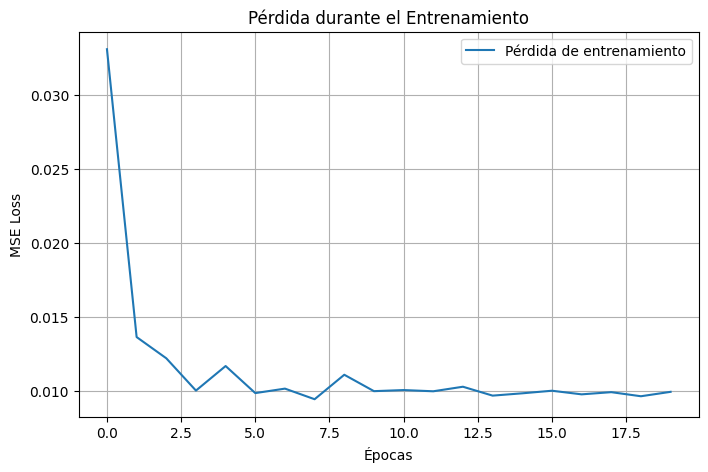

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

# Gráfico de pérdida (agrega validación si quieres monitorear overfitting)
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Pérdida de entrenamiento')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

## **Predicciones**

MSE: 4.9913, MAE: 1.7686


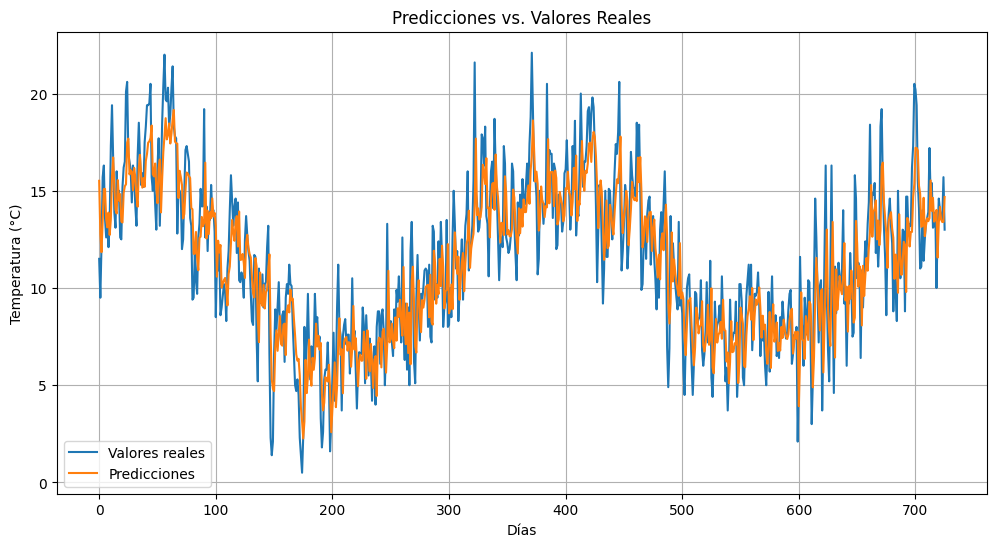

In [ ]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.cpu().numpy())

# Desnormalizar
predictions = scaler.inverse_transform(np.array(predictions))
actuals = scaler.inverse_transform(np.array(actuals))

# Métricas
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = math.sqrt(mse)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}')

# Gráfico de predicciones
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Valores reales')
plt.plot(predictions, label='Predicciones')
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

## **Series**

MSE: 4.9913, MAE: 1.7686, RMSE: 2.2341


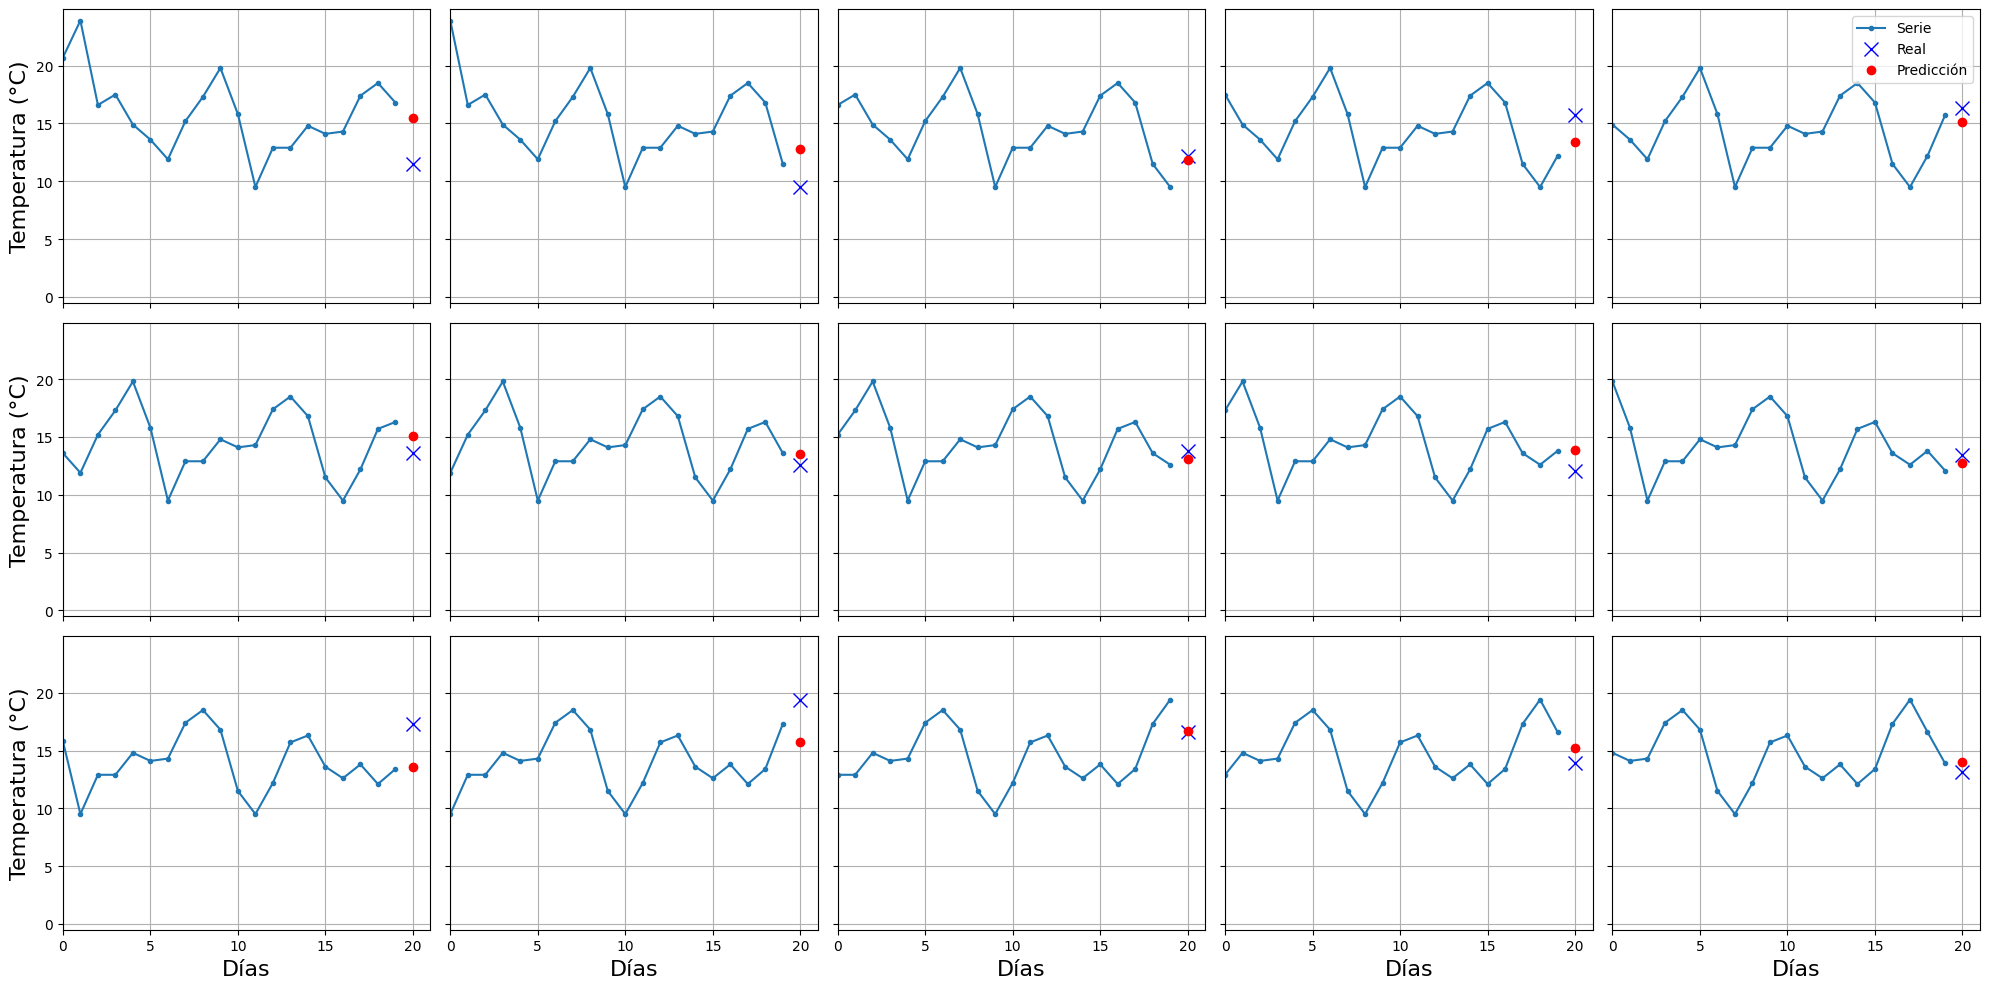

In [ ]:
def plot_series(series, y=None, y_pred=None, scaler=None, x_label="Días", y_label="Temperatura (°C)"):
    if scaler:
        series = scaler.inverse_transform(series.reshape(-1, 1)).reshape(series.shape)
        if y is not None:
            y = scaler.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
        if y_pred is not None:
            y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            ix = col + row * c
            if ix >= len(series):
                axes[row, col].axis('off')
                continue
            plt.sca(axes[row, col])
            plt.plot(series[ix, :, 0], ".-", label="Serie")
            if y is not None:
                plt.plot(range(len(series[ix, :, 0]), len(series[ix, :, 0]) + 1), y[ix], "bx", markersize=10, label="Real")
            if y_pred is not None:
                plt.plot(range(len(series[ix, :, 0]), len(series[ix, :, 0]) + 1), y_pred[ix], "ro", label="Predicción")
            plt.grid(True)
            plt.axis([0, len(series[ix, :, 0]) + 1, np.min(series) - 1, np.max(series) + 1])
            if x_label and row == r - 1:
                plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
                plt.ylabel(y_label, fontsize=16, rotation=90)
            if row == 0 and col == c - 1:
                plt.legend()
    plt.tight_layout()
    plt.show()

# Evaluación del modelo
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.cpu().numpy())

X_test_np = X_test.cpu().numpy()
series = X_test_np  # Usar las secuencias de entrada como 'series'

# Asegurar que predictions y actuals sean arrays 2D para plot_series
predictions = np.array(predictions).reshape(-1, 1)  # Forma: [num_samples, 1]
actuals = np.array(actuals).reshape(-1, 1)  # Forma: [num_samples, 1]

# Desnormalizar
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)
series = scaler.inverse_transform(series.reshape(-1, 1)).reshape(series.shape)  # Desnormalizar series

# Métricas
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = math.sqrt(mse)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# Gráfico con plot_series
plot_series(series, y=actuals, y_pred=predictions, scaler=None, x_label="Días", y_label="Temperatura (°C)")